<a href="https://colab.research.google.com/github/sandip01112004/MediScan/blob/main/Eye_diseases_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'eye-diseases-classification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2440665%2F4130910%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240606%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240606T130119Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D586c5250e1092d85ee627d4f945cf265f88d80a2566a3a7fce7d7a59bbf2d5c1001dc8c9d081b7ee76b3b1e5f31c1f72980b9287704a0b0fc6c54e1f83179ea0bbd3f06ccd1e9ab3ea90c02d2380fddcc0821f7a8380213cb9d16cfc47246ebaf5021500c67f198a7a07a523f3f29e857a838a9d7e58f1aff97fcc3bcc3441c024cb674a30cb643a482071e82bdccf9fa463f0b2dd77c83a52ebab4afdac9124c7d53b7e26221ca9de0986347111aec4b954fdee51566659fb49b7d2f3229454c72eb71575c92b6cfb47344cf1c23901802b8114e65a86c3ee5bb7f8cb8741f3155d39b7d3922e4ddb86ab335ea14596151d13970224a3290ad9ed1f4f2c229c'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 771355331 bytes downloaded
Downloaded and uncompressed: eye-diseases-classification
Data source import complete.


## Eye diseases

Diabetes is a condition that carries an increased risk of developing eye complications. Diabetic eye disease includes complications such as diabetic retinopathy, cataracts and glaucoma.

Diabetes is the leading cause of blindness in working-age adults. People with type 1 and type 2 diabetes are at risk. It’s possible to be unaware that you have severe diabetic eye disease and suddenly go blind. Fortunately, most cases of blindness can be prevented with regular eye examinations and proper care.

- The dataset consists of Normal, Diabetic Retinopathy, Cataract and Glaucoma retinal images where each class have approximately 1000 images. These images are collected from various sorces like IDRiD, Oculur recognition, HRF etc.

- Diabetic retinopathy: The persistently high blood sugar levels that occur with diabetes can damage the retina’s small blood vessels (capillaries), which deliver oxygen and nutrients. Diabetic retinopathy affects up to a third of people with diabetes over the age of 502.

- Cataracts: A cataract is a clouding of the lens in the eye. Left untreated, cataracts can eventually lead to blindness. People with diabetes are more likely to develop cataracts at an earlier age and suffer visual impairment faster than those without the condition.1,3

- Glaucoma: This is a group of conditions that can damage the optic nerve. The optic nerve transmits signals from the retina to the brain for processing. Glaucoma is often (but not always) a result of increased pressure inside the eye. The risk of glaucoma in people with diabetes is significantly higher than that of the general population.1,4 The two main types are open-angle glaucoma (also called ‘the sneak thief of sight’) and angle-closure glaucoma (this comes on suddenly and is a medical emergency).

## Import Libraries

In [2]:
# import system libs
import os
import time
# import data handling tools
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, Activation, GlobalAveragePooling2D
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

## Class for Loading and Splitting Datasets

In [3]:
class EyeDiseaseDataset:
    def __init__(self, dataDir):
        self.data_dir = dataDir

    def dataPaths(self):
        filepaths = []
        labels = []
        folds = os.listdir(self.data_dir)
        for fold in folds:
            foldPath = os.path.join(self.data_dir, fold)
            filelist = os.listdir(foldPath)
            for file in filelist:
                fpath = os.path.join(foldPath, file)
                filepaths.append(fpath)
                labels.append(fold)
        return filepaths, labels

    def dataFrame(self, files, labels):

        Fseries = pd.Series(files, name='filepaths')
        Lseries = pd.Series(labels, name='labels')
        return pd.concat([Fseries, Lseries], axis=1)

    def split_(self):
        files, labels = self.dataPaths()
        df = self.dataFrame(files, labels)
        strat = df['labels']
        trainData, dummyData = train_test_split(df, train_size=0.8, shuffle=True, random_state=42, stratify=strat)
        strat = dummyData['labels']
        validData, testData = train_test_split(dummyData, train_size=0.5, shuffle=True, random_state=42, stratify=strat)
        return trainData, validData, testData

In [4]:
dataDir='/kaggle/input/eye-diseases-classification/dataset'

In [5]:
dataSplit = EyeDiseaseDataset(dataDir)
train_data, valid_data, test_data = dataSplit.split_()

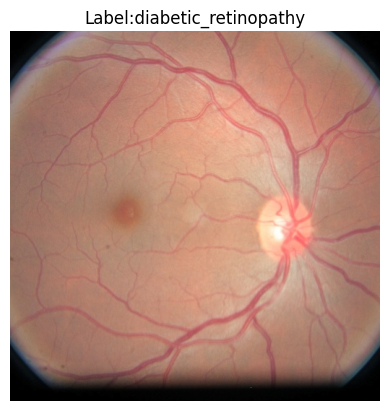

In [6]:
def display_random_image(df):
    random_row = df.sample(1).iloc[0]
    filepath = random_row['filepaths']
    label = random_row['labels']

    img = Image.open(filepath)
    plt.imshow(img)
    plt.title(f'Label:{label}')
    plt.axis('off')
    plt.show()

display_random_image(train_data)

## Function for Data Augmentation

In [7]:
def augment_data( train_df, valid_df, test_df, batch_size=16):

    img_size = (256,256)
    channels = 3
    color = 'rgb'


    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
              rotation_range=30,
              horizontal_flip=True,
              vertical_flip=True,
              brightness_range=[0.5, 1.5])

    valid_test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

    train_generator = train_datagen.flow_from_dataframe(
              train_df,
              x_col='filepaths',
              y_col='labels',
              target_size=img_size,
              color_mode=color,
              batch_size=batch_size,
              shuffle=True,
              class_mode='categorical'
          )

    print("Shape of augmented training images:", train_generator.image_shape)

    valid_generator = valid_test_datagen.flow_from_dataframe(
              valid_df,
              x_col='filepaths',
              y_col='labels',
              target_size=img_size,
              color_mode=color,
              batch_size=batch_size,
              shuffle=True,
              class_mode='categorical'
          )

    print("Shape of validation images:", valid_generator.image_shape)

    test_generator = valid_test_datagen.flow_from_dataframe(
              test_df,
              x_col='filepaths',
              y_col='labels',
              target_size=img_size,
              color_mode=color,
              batch_size=batch_size,
              shuffle=False,
              class_mode='categorical'
          )

    print("Shape of test images:", test_generator.image_shape)

    return train_generator, valid_generator, test_generator

In [8]:
train_augmented, valid_augmented, test_augmented = augment_data(train_data, valid_data, test_data)

Found 3373 validated image filenames belonging to 4 classes.
Shape of augmented training images: (256, 256, 3)
Found 422 validated image filenames belonging to 4 classes.
Shape of validation images: (256, 256, 3)
Found 422 validated image filenames belonging to 4 classes.
Shape of test images: (256, 256, 3)


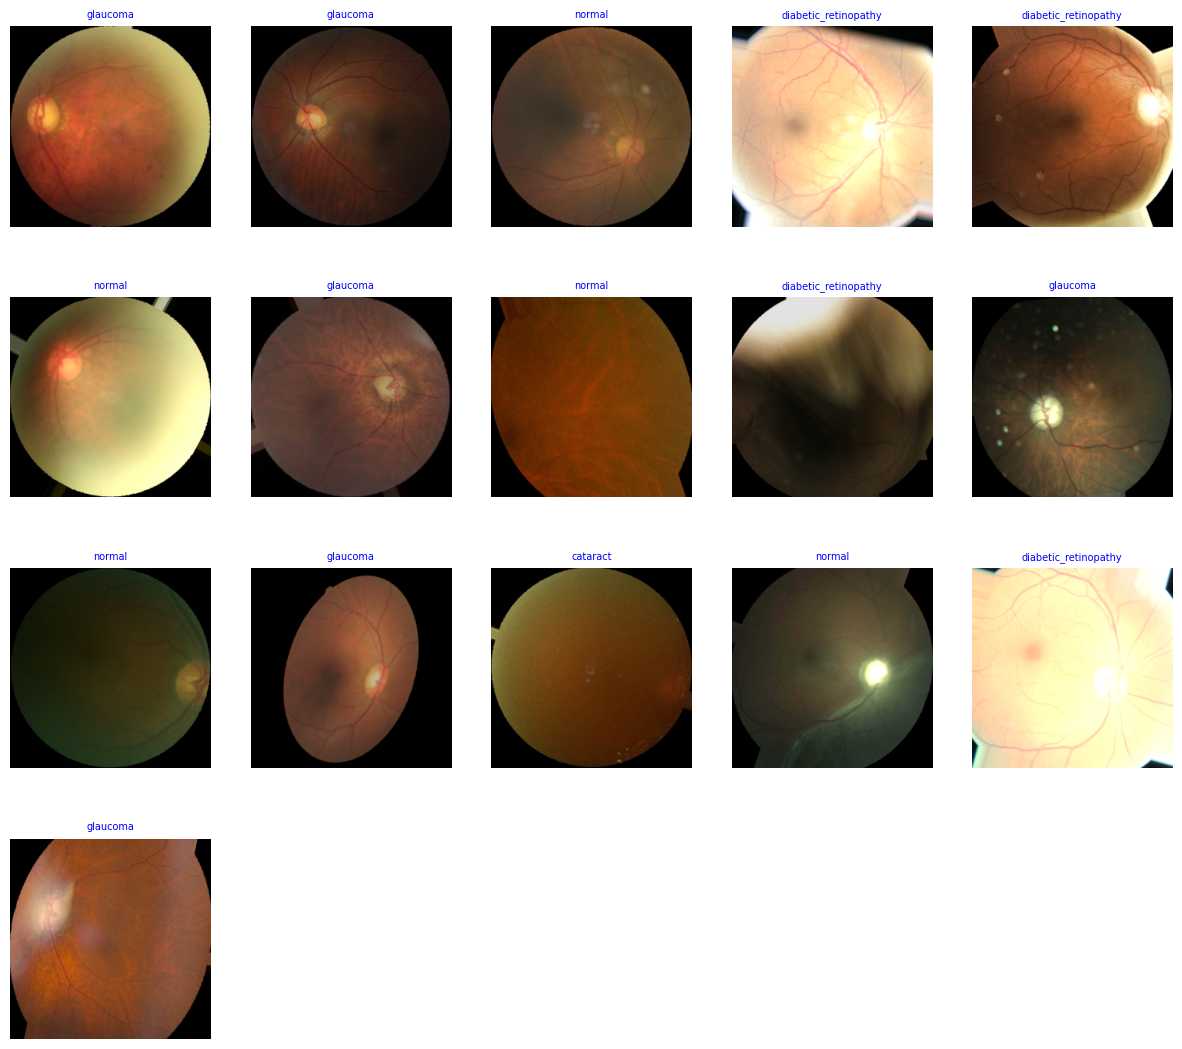

In [9]:
def show_images(gen):

    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(gen)        # get a batch size samples from the generator
    length = len(labels)
    sample = min(length, 20)
    plt.figure(figsize= (15, 17))
    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color= 'blue', fontsize= 7 )
        plt.axis('off')
    plt.show()
show_images(train_augmented)

## Download and compile the model

In [10]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import regularizers

classes = len(list(train_augmented.class_indices.keys()))

base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

for layer in base_model.layers:
    layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu' , kernel_regularizer = regularizers.l2(0.01))(x)

predictions = Dense(classes, activation='softmax', kernel_regularizer = regularizers.l2(0.01))(x)

model = Model(inputs=base_model.input, outputs=predictions)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

43941136/43941136 [==============================] - 0s 0us/step


## Fit the model

In [24]:
!git status


fatal: not a git repository (or any of the parent directories): .git
